In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Navigate to the desired directory in Google Drive
%cd /content/drive/My Drive/

# Clone the repository into Google Drive
!git clone https://github.com/Shadow-Junaid/Image-recognition-for-medical-diagnosis.git
%cd Image-recognition-for-medical-diagnosis

# List the contents of the directory
!ls


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00


In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import optuna
import pickle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# Utility functions for saving and loading
def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def save_metrics(metrics, filename):
    metrics_df = pd.DataFrame(metrics, index=['Accuracy', 'F1 Score', 'AUC-ROC', 'Precision', 'Sensitivity', 'Specificity', 'MCC']).T
    metrics_df.to_csv(filename)

def load_metrics(filename):
    return pd.read_csv(filename, index_col=0).to_dict()

def save_plot(figure, filename):
    figure.savefig(filename)

In [4]:
# Set the path for the dataset directory
base_dir = '/content/drive/My Drive/Image-recognition-for-medical-diagnosis'

# Define the paths for training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

            NORMAL  PNEUMONIA
Train         3312       8917
Validation     304        861
Test           171        411


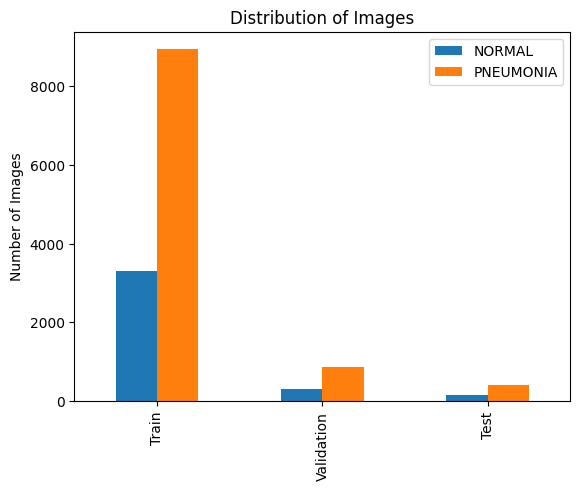

In [ ]:
# Function to count the number of images in each category
def count_images(directory):
    categories = ['NORMAL', 'PNEUMONIA']
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts

# Count images in each set
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Display the counts
data_counts = pd.DataFrame([train_counts, val_counts, test_counts], index=['Train', 'Validation', 'Test'])
print(data_counts)

# Plot the distribution of images
data_counts.plot(kind='bar', stacked=False)
plt.title('Distribution of Images')
plt.ylabel('Number of Images')
save_plot(plt, os.path.join(base_dir, 'image_distribution.jpg'))
plt.show()

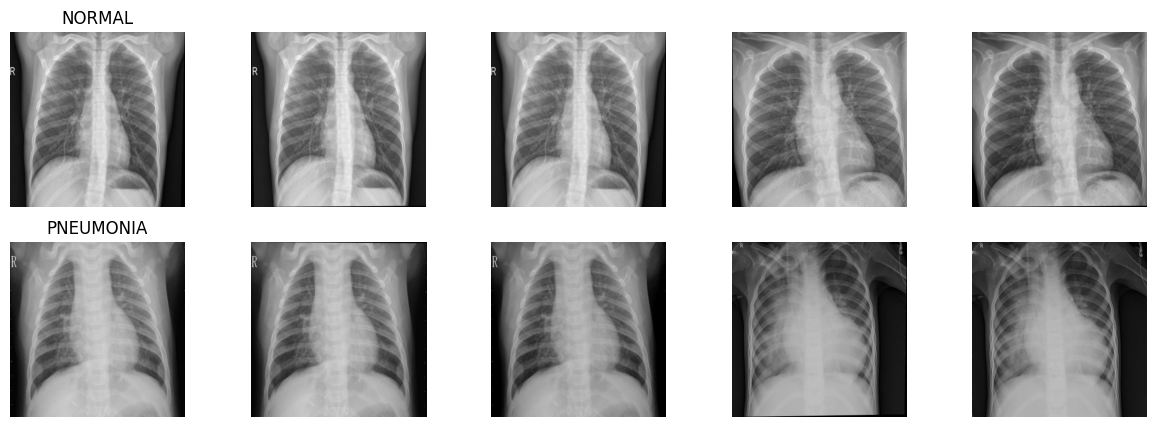

In [ ]:
import matplotlib.image as mpimg

# Function to plot example images from each category
def plot_example_images(directory, categories, num_images=5):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images = os.listdir(category_path)[:num_images]
        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)
    save_plot(fig, os.path.join(base_dir, 'example_images.jpg'))
    plt.show()

# Plot example images from the training set
plot_example_images(train_dir, ['NORMAL', 'PNEUMONIA'])

In [ ]:
# Load dataset
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

train_images, train_labels = load_images_from_folder(train_dir)
val_images, val_labels = load_images_from_folder(val_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Save loaded data
save_pickle((train_images, train_labels), os.path.join(base_dir, 'train_data.pkl'))
save_pickle((val_images, val_labels), os.path.join(base_dir, 'val_data.pkl'))
save_pickle((test_images, test_labels), os.path.join(base_dir, 'test_data.pkl'))

In [ ]:
# Extract SIFT features
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors_list.append(des)
    return descriptors_list

train_descriptors = extract_sift_features(train_images)
val_descriptors = extract_sift_features(val_images)
test_descriptors = extract_sift_features(test_images)

# Save descriptors
save_pickle(train_descriptors, os.path.join(base_dir, 'train_descriptors.pkl'))
save_pickle(val_descriptors, os.path.join(base_dir, 'val_descriptors.pkl'))
save_pickle(test_descriptors, os.path.join(base_dir, 'test_descriptors.pkl'))

In [ ]:
# Flatten the descriptors list
def flatten_descriptors(descriptors_list):
    all_descriptors = []
    for descriptors in descriptors_list:
        for des in descriptors:
            all_descriptors.append(des)
    return np.array(all_descriptors)

all_train_descriptors = flatten_descriptors(train_descriptors)

# KMeans clustering
num_clusters = 100  # You can choose a suitable number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_train_descriptors)

# Save KMeans model
save_pickle(kmeans, os.path.join(base_dir, 'kmeans.pkl'))

def construct_bovw(descriptors_list, kmeans):
    features = np.zeros((len(descriptors_list), num_clusters), dtype=np.float32)
    for i, descriptors in enumerate(descriptors_list):
        if descriptors is not None:
            clusters = kmeans.predict(descriptors)
            for cluster in clusters:
                features[i][cluster] += 1
    return features

train_features = construct_bovw(train_descriptors, kmeans)
val_features = construct_bovw(val_descriptors, kmeans)
test_features = construct_bovw(test_descriptors, kmeans)

# Standardize features
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Save features and scaler
save_pickle((train_features, val_features, test_features), os.path.join(base_dir, 'features.pkl'))
save_pickle(scaler, os.path.join(base_dir, 'scaler.pkl'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Save the label encoder
save_pickle(label_encoder, os.path.join(base_dir, 'label_encoder.pkl'))

In [ ]:
# Define models
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}

# Train and predict with models
preds = {}
probs = {}
for name, model in models.items():
    model.fit(train_features, train_labels_encoded)
    preds[name] = model.predict(test_features)
    probs[name] = model.predict_proba(test_features)[:, 1]

    # Save models
    save_pickle(model, os.path.join(base_dir, f'{name}_model.pkl'))
    # Save predictions
    save_pickle(preds[name], os.path.join(base_dir, f'{name}_preds.pkl'))
    save_pickle(probs[name], os.path.join(base_dir, f'{name}_probs.pkl'))

# Evaluate classifiers
def evaluate_model(true_labels, pred_labels, pred_probs):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    auc_roc = roc_auc_score(true_labels, pred_probs)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    mcc = matthews_corrcoef(true_labels, pred_labels)

    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    specificity = tn / (tn + fp)

    return accuracy, f1, auc_roc, precision, recall, specificity, mcc

metrics = {name: evaluate_model(test_labels_encoded, preds[name], probs[name]) for name in models.keys()}

print(metrics)

# Save metrics
save_metrics(metrics, os.path.join(base_dir, 'initial_metrics.csv'))

{'SVM': (0.9106529209621993, 0.911094672493953, 0.9587086125695423, 0.911756546575115, 0.9106529209621993, 0.8654970760233918, 0.7871142719003538), 'KNN': (0.8762886597938144, 0.8779966148638253, 0.9235212930948621, 0.8815276169490383, 0.8762886597938144, 0.8421052631578947, 0.7126369125323588), 'Random Forest': (0.872852233676976, 0.875267332854321, 0.9423741836342681, 0.8814058514618461, 0.872852233676976, 0.8596491228070176, 0.710409376677465), 'Naive Bayes': (0.8109965635738832, 0.8179143492553622, 0.8840938518233945, 0.8444184572050218, 0.8109965635738832, 0.8654970760233918, 0.6069841245537866)}


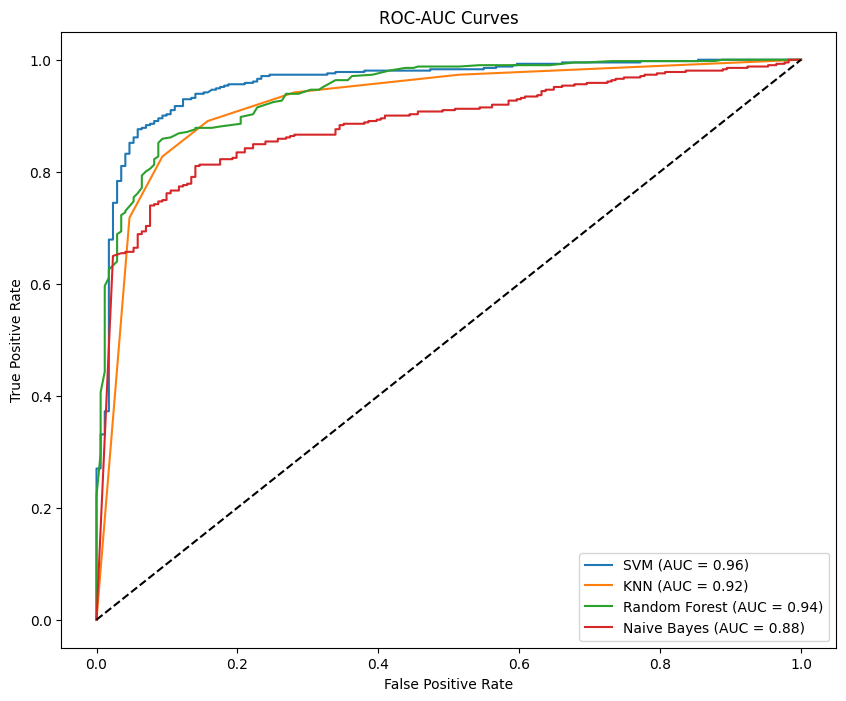

In [ ]:
# Plot ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model_probs in probs.items():
    fpr, tpr, _ = roc_curve(test_labels_encoded, model_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(test_labels_encoded, model_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves')
plt.legend()

# Save plot
save_plot(plt, os.path.join(base_dir, 'initial_roc_auc_curves.jpg'))
plt.show()

In [ ]:
# Optuna for hyperparameter tuning
def objective(trial, model_name):
    if model_name == "SVM":
        C = trial.suggest_loguniform('C', 1e-5, 1e2)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        model = SVC(C=C, kernel=kernel, probability=True)
    elif model_name == "KNN":
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model_name == "Random Forest":
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif model_name == "Naive Bayes":
        var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
        model = GaussianNB(var_smoothing=var_smoothing)

    model.fit(train_features, train_labels_encoded)
    preds = model.predict(test_features)
    probs = model.predict_proba(test_features)[:, 1]
    return roc_auc_score(test_labels_encoded, probs)

# Perform hyperparameter tuning
best_params = {}
for name in models.keys():
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, name), n_trials=50)
    best_params[name] = study.best_params

    # Save best params
    save_pickle(best_params, os.path.join(base_dir, 'best_params.pkl'))

[I 2024-07-01 15:31:34,834] A new study created in memory with name: no-name-63502004-ca5b-45a1-9a3d-0e7b4b01cf95
<ipython-input-17-967baaca7958>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-07-01 15:32:06,283] Trial 0 finished with value: 0.9589931845022125 and parameters: {'C': 0.04261783070102095, 'kernel': 'linear'}. Best is trial 0 with value: 0.9589931845022125.
<ipython-input-17-967baaca7958>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-07-01 15:32:30,866] Trial 1 finished with value: 0.8308362146241516 and parameters: {'C': 47.81415294988303, 'kernel

In [ ]:
# Retrain and evaluate tuned models
tuned_preds = {}
tuned_probs = {}
tuned_metrics = {}

for name, params in best_params.items():
    if name == "SVM":
        model = SVC(**params, probability=True)
    elif name == "KNN":
        model = KNeighborsClassifier(**params)
    elif name == "Random Forest":
        model = RandomForestClassifier(**params)
    elif name == "Naive Bayes":
        model = GaussianNB(**params)

    model.fit(train_features, train_labels_encoded)
    tuned_preds[name] = model.predict(test_features)
    tuned_probs[name] = model.predict_proba(test_features)[:, 1]
    tuned_metrics[name] = evaluate_model(test_labels_encoded, tuned_preds[name], tuned_probs[name])

    # Save tuned models
    save_pickle(model, os.path.join(base_dir, f'{name}_tuned_model.pkl'))
    # Save tuned predictions
    save_pickle(tuned_preds[name], os.path.join(base_dir, f'{name}_tuned_preds.pkl'))
    save_pickle(tuned_probs[name], os.path.join(base_dir, f'{name}_tuned_probs.pkl'))

# Save tuned metrics
save_metrics(tuned_metrics, os.path.join(base_dir, 'tuned_metrics.csv'))

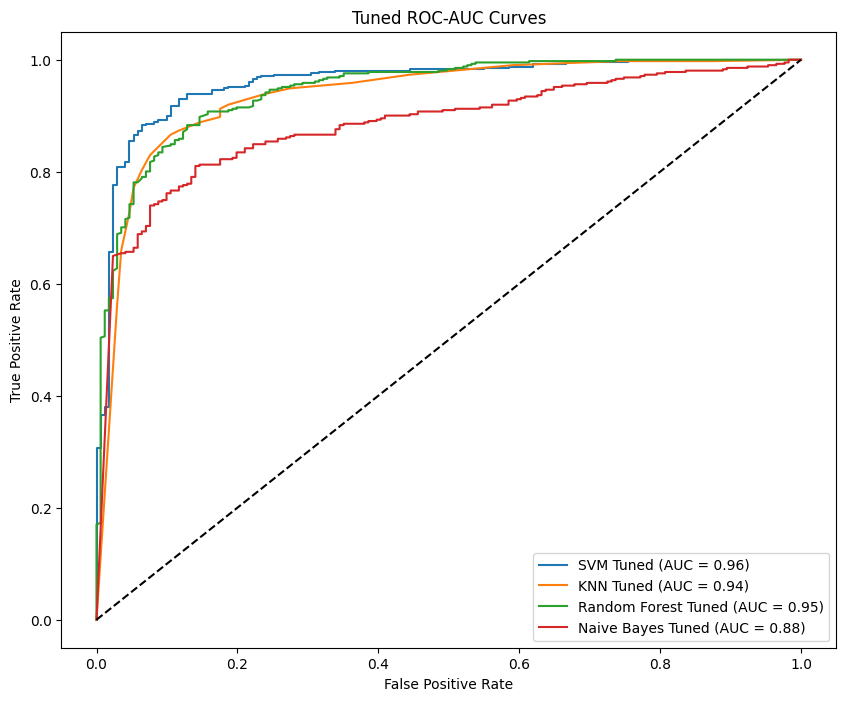

In [ ]:
# Plot tuned ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model_probs in tuned_probs.items():
    fpr, tpr, _ = roc_curve(test_labels_encoded, model_probs)
    plt.plot(fpr, tpr, label=f"{name} Tuned (AUC = {roc_auc_score(test_labels_encoded, model_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned ROC-AUC Curves')
plt.legend()

# Save plot
save_plot(plt, os.path.join(base_dir, 'tuned_roc_auc_curves.jpg'))
plt.show()

In [ ]:
# Prepare data for CNN
def prepare_data_for_cnn(images, labels):
    images_resized = [cv2.resize(img, (224, 224)) for img in images]
    images_array = np.array(images_resized)
    images_array = images_array.reshape(-1, 224, 224, 1).astype('float32') / 255.0
    labels_array = label_encoder.transform(labels)
    return images_array, labels_array

train_images_cnn, train_labels_cnn = prepare_data_for_cnn(train_images, train_labels)
val_images_cnn, val_labels_cnn = prepare_data_for_cnn(val_images, val_labels)
test_images_cnn, test_labels_cnn = prepare_data_for_cnn(test_images, test_labels)

# Save CNN data
save_pickle((train_images_cnn, train_labels_cnn), os.path.join(base_dir, 'train_cnn_data.pkl'))
save_pickle((val_images_cnn, val_labels_cnn), os.path.join(base_dir, 'val_cnn_data.pkl'))
save_pickle((test_images_cnn, test_labels_cnn), os.path.join(base_dir, 'test_cnn_data.pkl'))

# Define and compile CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Save CNN model architecture
cnn_model_json = cnn_model.to_json()
with open(os.path.join(base_dir, "cnn_model.json"), "w") as json_file:
    json_file.write(cnn_model_json)


In [7]:
import os
import pickle
from keras.models import model_from_json

# Function to load pickled data
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Load training data
train_cnn_data = load_pickle(os.path.join(base_dir, 'train_cnn_data.pkl'))
train_images_cnn, train_labels_cnn = train_cnn_data

# Load validation data
val_cnn_data = load_pickle(os.path.join(base_dir, 'val_cnn_data.pkl'))
val_images_cnn, val_labels_cnn = val_cnn_data

# Load test data
test_cnn_data = load_pickle(os.path.join(base_dir, 'test_cnn_data.pkl'))
test_images_cnn, test_labels_cnn = test_cnn_data

# Load CNN model architecture
with open(os.path.join(base_dir, "cnn_model.json"), "r") as json_file:
    cnn_model_json = json_file.read()
    cnn_model = model_from_json(cnn_model_json)

In [10]:
# Define and compile CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Save CNN model architecture
cnn_model_json = cnn_model.to_json()
with open(os.path.join(base_dir, "cnn_model.json"), "w") as json_file:
    json_file.write(cnn_model_json)

# Train CNN model
cnn_history = cnn_model.fit(train_images_cnn, train_labels_cnn, epochs=50, validation_data=(val_images_cnn, val_labels_cnn), callbacks=[early_stopping])

# Save CNN model weights
cnn_model.save_weights(os.path.join(base_dir, "cnn_model_weights.h5"))

# Save CNN training history
save_pickle(cnn_history.history, os.path.join(base_dir, 'cnn_history.pkl'))

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_images_cnn, test_labels_cnn)
cnn_preds = cnn_model.predict(test_images_cnn).flatten()
cnn_pred_labels = (cnn_preds > 0.5).astype(int)

Epoch 1/50
383/383 [==============================] - 21s 48ms/step - loss: 0.2254 - accuracy: 0.9102 - val_loss: 0.1423 - val_accuracy: 0.9399
Epoch 2/50
383/383 [==============================] - 18s 46ms/step - loss: 0.1361 - accuracy: 0.9491 - val_loss: 0.1047 - val_accuracy: 0.9631
Epoch 3/50
383/383 [==============================] - 18s 46ms/step - loss: 0.0997 - accuracy: 0.9607 - val_loss: 0.0984 - val_accuracy: 0.9597
Epoch 4/50
383/383 [==============================] - 18s 46ms/step - loss: 0.0742 - accuracy: 0.9720 - val_loss: 0.1104 - val_accuracy: 0.9682
Epoch 5/50
383/383 [==============================] - 18s 46ms/step - loss: 0.0528 - accuracy: 0.9800 - val_loss: 0.1370 - val_accuracy: 0.9648
Epoch 6/50
383/383 [==============================] - 17s 45ms/step - loss: 0.0413 - accuracy: 0.9832 - val_loss: 0.1729 - val_accuracy: 0.9605
Epoch 7/50
383/383 [==============================] - 17s 46ms/step - loss: 0.0400 - accuracy: 0.9832 - val_loss: 0.1713 - val_accuracy:

In [11]:
def evaluate_model(true_labels, pred_labels, pred_probs):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    auc_roc = roc_auc_score(true_labels, pred_probs)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    mcc = matthews_corrcoef(true_labels, pred_labels)

    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    specificity = tn / (tn + fp)

    return accuracy, f1, auc_roc, precision, recall, specificity, mcc

cnn_metrics = evaluate_model(test_labels_cnn, cnn_pred_labels, cnn_preds)

# Save CNN metrics
save_metrics(cnn_metrics, os.path.join(base_dir, 'cnn_metrics.csv'))

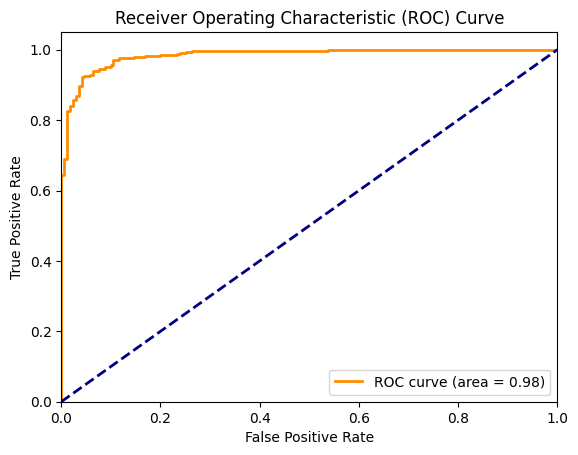

In [16]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels_cnn, cnn_preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save plot
save_plot(plt, os.path.join(base_dir, 'CNN_roc_auc_curve.jpg'))
plt.show()

In [13]:
import os
import pandas as pd

# Function to load metrics from a CSV file
def load_metrics(file_path):
    return pd.read_csv(file_path)

# Load initial metrics
initial_metrics = load_metrics(os.path.join(base_dir, 'initial_metrics.csv'))

# Load tuned metrics
tuned_metrics = load_metrics(os.path.join(base_dir, 'tuned_metrics.csv'))

# Load cnn metrics
cnn_metrics = load_metrics(os.path.join(base_dir, 'cnn_metrics.csv'))

In [19]:
# Display the loaded metrics
print("Initial Metrics:")
initial_metrics.head()

Initial Metrics:


,Unnamed: 0,Accuracy,F1 Score,AUC-ROC,Precision,Sensitivity,Specificity,MCC
0,SVM,0.910653,0.911095,0.958709,0.911757,0.910653,0.865497,0.787114
1,KNN,0.876289,0.877997,0.923521,0.881528,0.876289,0.842105,0.712637
2,Random Forest,0.872852,0.875267,0.942374,0.881406,0.872852,0.859649,0.710409
3,Naive Bayes,0.810997,0.817914,0.884094,0.844418,0.810997,0.865497,0.606984


In [20]:
print("\nTuned Metrics:")
tuned_metrics.head()


Tuned Metrics:


,Unnamed: 0,Accuracy,F1 Score,AUC-ROC,Precision,Sensitivity,Specificity,MCC
0,SVM,0.914089,0.914514,0.959320,0.915160,0.914089,0.871345,0.795314
1,KNN,0.878007,0.879936,0.936853,0.884339,0.878007,0.853801,0.718736
2,Random Forest,0.881443,0.883161,0.945839,0.886921,0.881443,0.853801,0.725390
3,Naive Bayes,0.810997,0.817914,0.884094,0.844418,0.810997,0.865497,0.606984


In [15]:
# Display the loaded metrics
print("CNN Metrics:")
cnn_metrics.head()

CNN Metrics:


,Unnamed: 0,Accuracy,F1 Score,AUC-ROC,Precision,Sensitivity,Specificity,MCC
0,0,0.939863,0.939914,0.984334,0.939971,0.939863,0.900585,0.855336


In [13]:
# Summary of all models' metrics
models_metrics = {
    "SVM": metrics["SVM"],
    "KNN": metrics["KNN"],
    "Random Forest": metrics["Random Forest"],
    "Naive Bayes": metrics["Naive Bayes"],
    "CNN": cnn_metrics
}

tuned_models_metrics = {
    "SVM": tuned_metrics["SVM"],
    "KNN": tuned_metrics["KNN"],
    "Random Forest": tuned_metrics["Random Forest"],
    "Naive Bayes": tuned_metrics["Naive Bayes"],
    "CNN": cnn_metrics
}

# Save all metrics
save_metrics(models_metrics, os.path.join(base_dir, 'models_metrics.csv'))
save_metrics(tuned_models_metrics, os.path.join(base_dir, 'tuned_models_metrics.csv'))

NameError: name 'metrics' is not defined

In [ ]:
# Print metrics before and after tuning
for model_name, metrics in models_metrics.items():
    print(f"{model_name} Metrics: ")
    print(f"Accuracy: {metrics[0]}")
    print(f"F1 Score: {metrics[1]}")
    print(f"AUC-ROC: {metrics[2]}")
    print(f"Precision: {metrics[3]}")
    print(f"Sensitivity: {metrics[4]}")
    print(f"Specificity: {metrics[5]}")
    print(f"MCC: {metrics[6]}\n")

print("Metrics after hyperparameter tuning:\n")
for model_name, metrics in tuned_models_metrics.items():
    print(f"{model_name} Tuned Metrics: ")
    print(f"Accuracy: {metrics[0]}")
    print(f"F1 Score: {metrics[1]}")
    print(f"AUC-ROC: {metrics[2]}")
    print(f"Precision: {metrics[3]}")
    print(f"Sensitivity: {metrics[4]}")
    print(f"Specificity: {metrics[5]}")
    print(f"MCC: {metrics[6]}\n")

In [ ]:











# Create ImageDataGenerator objects for training, validation, and testing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Test data generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 12229 images belonging to 2 classes.
Found 1165 images belonging to 2 classes.
Found 582 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # You can set a high number of epochs since EarlyStopping will halt training early if no improvement
    callbacks=[early_stopping]
)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/50
96/96 [==============================] - 97s 754ms/step - loss: 0.2422 - accuracy: 0.9114 - val_loss: 0.0930 - val_accuracy: 0.9657
Epoch 2/50
96/96 [==============================] - 65s 676ms/step - loss: 0.0897 - accuracy: 0.9697 - val_loss: 0.0853 - val_accuracy: 0.9708
Epoch 3/50
96/96 [==============================] - 63s 658ms/step - loss: 0.0697 - accuracy: 0.9764 - val_loss: 0.0726 - val_accuracy: 0.9751
Epoch 4/50
96/96 [==============================] - 62s 641ms/step - loss: 0.0531 - accuracy: 0.9832 - val_loss: 0.0669 - val_accuracy: 0.9811
Epoch 5/50
96/96 [==============================] - 62s 641ms/step - loss: 0.0436 - accuracy: 0.9877 - val_loss: 0.0830 - val_accuracy: 0.9674
Epoch 6/50
96/96 [==============================] - 62s 640ms/step - loss: 0.0353 - accuracy: 0.9916 - val_loss: 0.0668 - val_accuracy: 0.9803
Epoch 7/50
96/96 [==============================] - 63s 656ms/step - loss: 0.

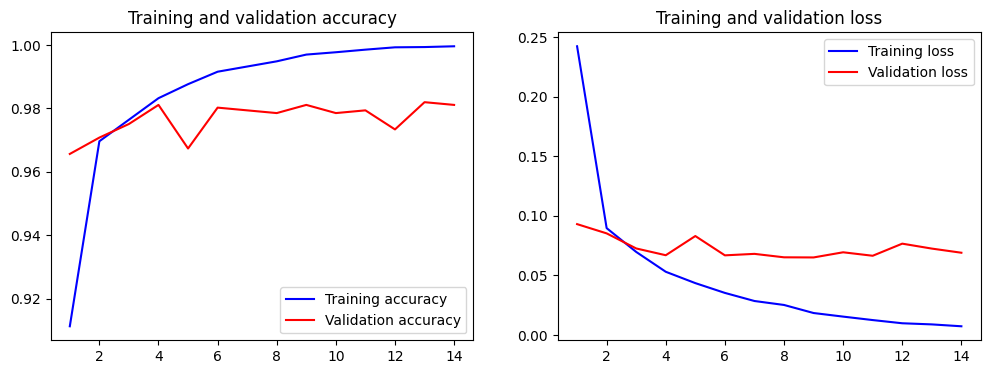

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)


5/5 [==============================] - 5s 798ms/step
Test Accuracy: 0.5807560137457045
F1 Score: 0.7067307692307693
AUC-ROC: 0.47960330672585766


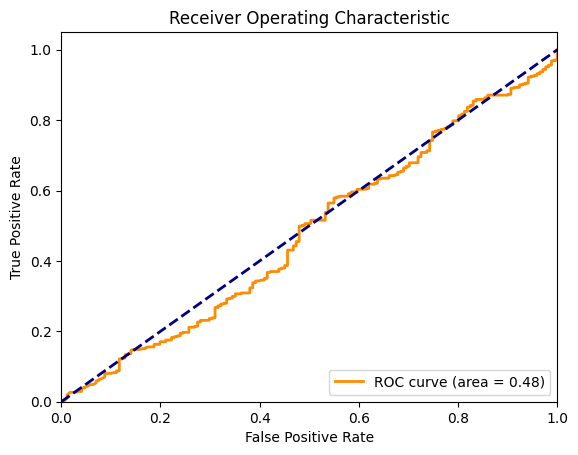

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np

# Get the ground truth labels and predicted probabilities
test_labels = test_generator.classes
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
test_pred_labels = (test_predictions > 0.5).astype(int).flatten()

# Calculate metrics
test_accuracy = np.mean(test_pred_labels == test_labels)
test_f1_score = f1_score(test_labels, test_pred_labels)
test_auc_roc = roc_auc_score(test_labels, test_predictions)

print(f'Test Accuracy: {test_accuracy}')
print(f'F1 Score: {test_f1_score}')
print(f'AUC-ROC: {test_auc_roc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Fine-tuning the model
# Unfreeze some layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True
# Recompile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback for fine-tuning
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Continue training the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Set a high number of epochs since EarlyStopping will halt training early if no improvement
    callbacks=[fine_tune_early_stopping]
)


Epoch 1/50
96/96 [==============================] - 76s 746ms/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.0816 - val_accuracy: 0.9768
Epoch 2/50
96/96 [==============================] - 74s 767ms/step - loss: 0.0039 - accuracy: 0.9998 - val_loss: 0.0809 - val_accuracy: 0.9811
Epoch 3/50
96/96 [==============================] - 69s 718ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9837
Epoch 4/50
96/96 [==============================] - 70s 723ms/step - loss: 9.7652e-04 - accuracy: 1.0000 - val_loss: 0.0831 - val_accuracy: 0.9845
Epoch 5/50
96/96 [==============================] - 69s 719ms/step - loss: 6.3228e-04 - accuracy: 1.0000 - val_loss: 0.0892 - val_accuracy: 0.9811
Epoch 6/50
96/96 [==============================] - 69s 721ms/step - loss: 4.6709e-04 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9811
Epoch 7/50
96/96 [==============================] - 68s 707ms/step - loss: 3.4804e-04 - accuracy: 1.0000 - val_loss: 0.0927 - val_

5/5 [==============================] - 3s 523ms/step - loss: 0.0851 - accuracy: 0.9811
Fine-tuned Test Accuracy: 0.9810996651649475
5/5 [==============================] - 3s 576ms/step
Fine-tuned Test Accuracy: 0.6237113402061856
Fine-tuned F1 Score: 0.7358262967430639
Fine-tuned AUC-ROC: 0.5438169633329065


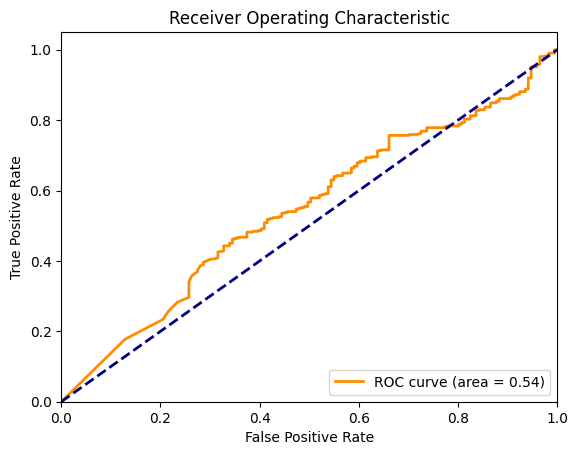

In [ ]:
# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(test_generator)
print(f'Fine-tuned Test Accuracy: {fine_tune_accuracy}')

# Get the ground truth labels and predicted probabilities after fine-tuning
fine_tune_test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
fine_tune_test_pred_labels = (fine_tune_test_predictions > 0.5).astype(int).flatten()

# Calculate metrics after fine-tuning
fine_tune_test_accuracy = np.mean(fine_tune_test_pred_labels == test_labels)
fine_tune_test_f1_score = f1_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_auc_roc = roc_auc_score(test_labels, fine_tune_test_predictions)

print(f'Fine-tuned Test Accuracy: {fine_tune_test_accuracy}')
print(f'Fine-tuned F1 Score: {fine_tune_test_f1_score}')
print(f'Fine-tuned AUC-ROC: {fine_tune_test_auc_roc}')

# Plot ROC curve after fine-tuning
fpr, tpr, _ = roc_curve(test_labels, fine_tune_test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % fine_tune_test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# **Implementing Data Augmentation to improve variability**

In [ ]:
# Create ImageDataGenerator objects for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    validation_split=0.2
)

# Validation and test data generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    subset='training'
)

# Validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    subset='validation'
)

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)

Found 9784 images belonging to 2 classes.
Found 2445 images belonging to 2 classes.
Found 582 images belonging to 2 classes.


# **Introducing class weights for proper balancing of data.**

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.layers import Dropout

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,  # Add class weights here
    callbacks=[early_stopping]
)

Epoch 1/50
77/77 [==============================] - 195s 2s/step - loss: 0.4261 - accuracy: 0.8161 - val_loss: 0.2486 - val_accuracy: 0.8998
Epoch 2/50
77/77 [==============================] - 188s 2s/step - loss: 0.2478 - accuracy: 0.8980 - val_loss: 0.2530 - val_accuracy: 0.8904
Epoch 3/50
77/77 [==============================] - 186s 2s/step - loss: 0.2327 - accuracy: 0.9030 - val_loss: 0.1924 - val_accuracy: 0.9243
Epoch 4/50
77/77 [==============================] - 199s 3s/step - loss: 0.2145 - accuracy: 0.9129 - val_loss: 0.1945 - val_accuracy: 0.9223
Epoch 5/50
77/77 [==============================] - 182s 2s/step - loss: 0.2153 - accuracy: 0.9119 - val_loss: 0.2163 - val_accuracy: 0.9092
Epoch 6/50
77/77 [==============================] - 184s 2s/step - loss: 0.1969 - accuracy: 0.9230 - val_loss: 0.1617 - val_accuracy: 0.9333
Epoch 7/50
77/77 [==============================] - 182s 2s/step - loss: 0.1967 - accuracy: 0.9210 - val_loss: 0.2383 - val_accuracy: 0.9051
Epoch 8/50
77

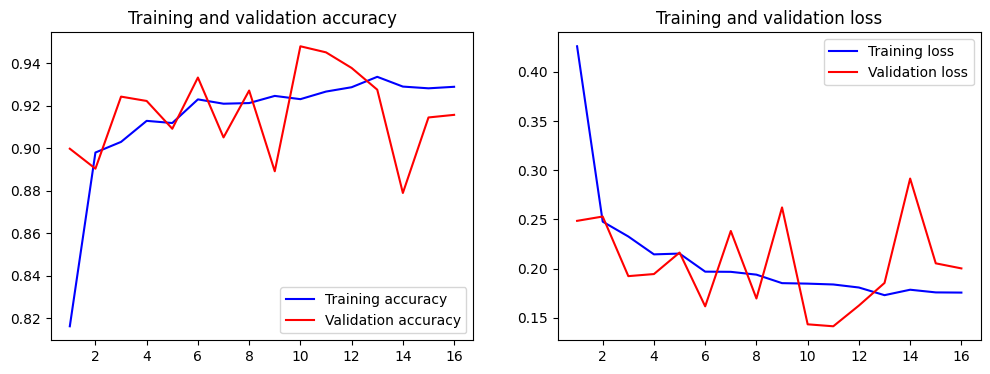

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

5/5 [==============================] - 3s 594ms/step
Test Accuracy: 0.5652920962199313
F1 Score: 0.6760563380281691
AUC-ROC: 0.5152317126961767


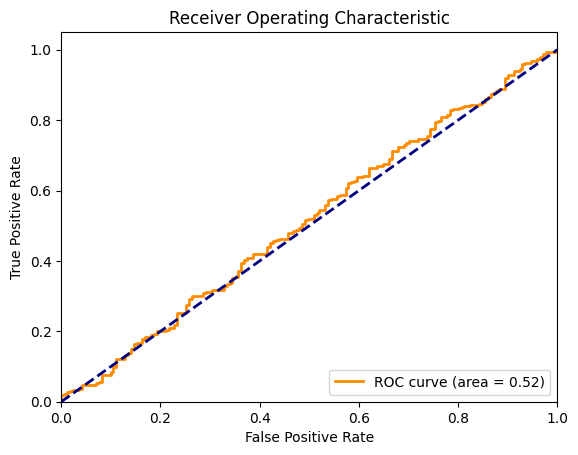

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np

# Get the ground truth labels and predicted probabilities
test_labels = test_generator.classes
test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
test_pred_labels = (test_predictions > 0.5).astype(int).flatten()

# Calculate metrics
test_accuracy = np.mean(test_pred_labels == test_labels)
test_f1_score = f1_score(test_labels, test_pred_labels)
test_auc_roc = roc_auc_score(test_labels, test_predictions)

print(f'Test Accuracy: {test_accuracy}')
print(f'F1 Score: {test_f1_score}')
print(f'AUC-ROC: {test_auc_roc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


5/5 [==============================] - 3s 549ms/step - loss: 0.1938 - accuracy: 0.9158
Fine-tuned Test Accuracy: 0.9158075451850891
5/5 [==============================] - 3s 583ms/step
Fine-tuned Test Accuracy: 0.5756013745704467
Fine-tuned F1 Score: 0.6837387964148527
Fine-tuned AUC-ROC: 0.5284216217754444


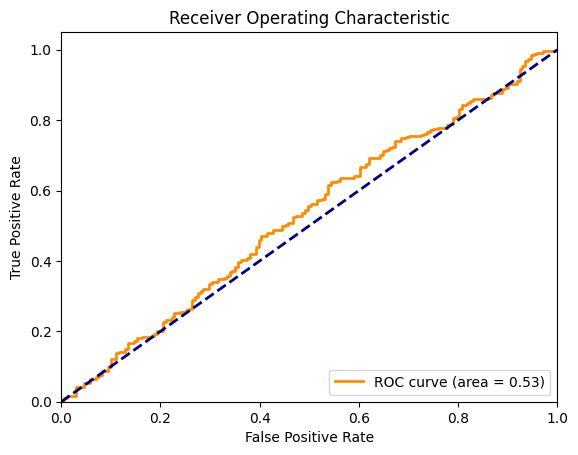

In [ ]:
# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(test_generator)
print(f'Fine-tuned Test Accuracy: {fine_tune_accuracy}')

# Get the ground truth labels and predicted probabilities after fine-tuning
fine_tune_test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
fine_tune_test_pred_labels = (fine_tune_test_predictions > 0.5).astype(int).flatten()

# Calculate metrics after fine-tuning
fine_tune_test_accuracy = np.mean(fine_tune_test_pred_labels == test_labels)
fine_tune_test_f1_score = f1_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_auc_roc = roc_auc_score(test_labels, fine_tune_test_predictions)

print(f'Fine-tuned Test Accuracy: {fine_tune_test_accuracy}')
print(f'Fine-tuned F1 Score: {fine_tune_test_f1_score}')
print(f'Fine-tuned AUC-ROC: {fine_tune_test_auc_roc}')

# Plot ROC curve after fine-tuning
fpr, tpr, _ = roc_curve(test_labels, fine_tune_test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % fine_tune_test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Create ImageDataGenerator objects for training, validation, and testing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)

# Test data generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)

Found 12229 images belonging to 2 classes.
Found 1165 images belonging to 2 classes.
Found 582 images belonging to 2 classes.


In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model using SGDM
sgd = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define class weights if necessary, e.g.,
# class_weights = {0: 1.0, 1: 1.0}

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,  # Ensure you define class_weights if needed
    callbacks=[early_stopping]
)


Epoch 1/50
96/96 [==============================] - 66s 678ms/step - loss: 0.5015 - accuracy: 0.7506 - val_loss: 0.3726 - val_accuracy: 0.8438
Epoch 2/50
96/96 [==============================] - 64s 665ms/step - loss: 0.3213 - accuracy: 0.8733 - val_loss: 0.2722 - val_accuracy: 0.8979
Epoch 3/50
96/96 [==============================] - 63s 651ms/step - loss: 0.2690 - accuracy: 0.8946 - val_loss: 0.2258 - val_accuracy: 0.9133
Epoch 4/50
96/96 [==============================] - 66s 683ms/step - loss: 0.2448 - accuracy: 0.9042 - val_loss: 0.2098 - val_accuracy: 0.9167
Epoch 5/50
96/96 [==============================] - 63s 652ms/step - loss: 0.2261 - accuracy: 0.9104 - val_loss: 0.1967 - val_accuracy: 0.9236
Epoch 6/50
96/96 [==============================] - 61s 636ms/step - loss: 0.2077 - accuracy: 0.9240 - val_loss: 0.1999 - val_accuracy: 0.9185
Epoch 7/50
96/96 [==============================] - 63s 650ms/step - loss: 0.1999 - accuracy: 0.9248 - val_loss: 0.1922 - val_accuracy: 0.9236

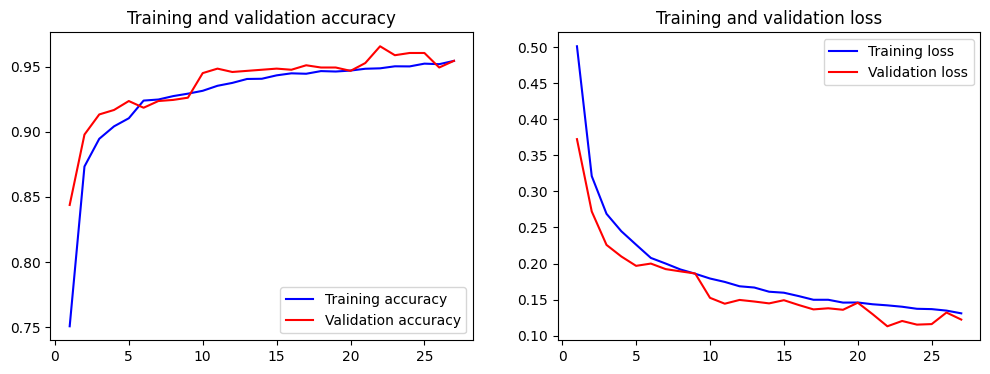

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

5/5 [==============================] - 3s 480ms/step - loss: 0.1313 - accuracy: 0.9467
Fine-tuned Test Accuracy: 0.9467353820800781
5/5 [==============================] - 3s 545ms/step
Fine-tuned Test Accuracy: 0.5687285223367697
Fine-tuned F1 Score: 0.6942752740560293
Fine-tuned AUC-ROC: 0.507847071043383


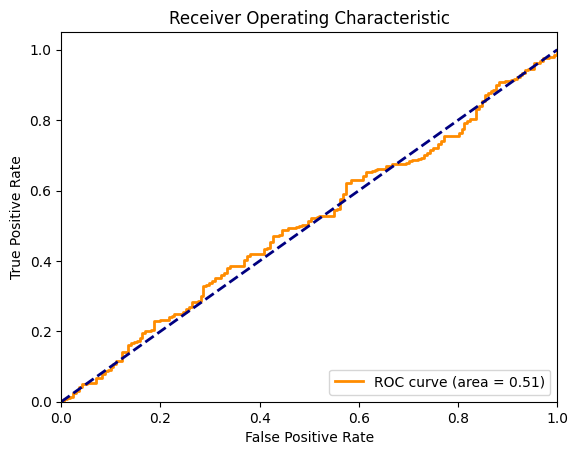

In [ ]:
# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(test_generator)
print(f'Fine-tuned Test Accuracy: {fine_tune_accuracy}')

# Get the ground truth labels and predicted probabilities after fine-tuning
fine_tune_test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
fine_tune_test_pred_labels = (fine_tune_test_predictions > 0.5).astype(int).flatten()

# Calculate metrics after fine-tuning
fine_tune_test_accuracy = np.mean(fine_tune_test_pred_labels == test_labels)
fine_tune_test_f1_score = f1_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_auc_roc = roc_auc_score(test_labels, fine_tune_test_predictions)

print(f'Fine-tuned Test Accuracy: {fine_tune_test_accuracy}')
print(f'Fine-tuned F1 Score: {fine_tune_test_f1_score}')
print(f'Fine-tuned AUC-ROC: {fine_tune_test_auc_roc}')

# Plot ROC curve after fine-tuning
fpr, tpr, _ = roc_curve(test_labels, fine_tune_test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % fine_tune_test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout

# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model using RMSprop
rmsprop = RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define class weights if necessary, e.g.,
# class_weights = {0: 1.0, 1: 1.0}

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,  # Ensure you define class_weights if needed
    callbacks=[early_stopping]
)

Epoch 1/50
383/383 [==============================] - 8331s 22s/step - loss: 0.2436 - accuracy: 0.9105 - val_loss: 0.1699 - val_accuracy: 0.9322
Epoch 2/50
383/383 [==============================] - 8250s 22s/step - loss: 0.1475 - accuracy: 0.9477 - val_loss: 0.1655 - val_accuracy: 0.9391
Epoch 3/50
239/383 [=================>............] - ETA: 47:09 - loss: 0.1218 - accuracy: 0.9567

KeyboardInterrupt: 

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate the fine-tuned model
fine_tune_loss, fine_tune_accuracy = model.evaluate(test_generator)
print(f'Fine-tuned Test Accuracy: {fine_tune_accuracy}')

# Get the ground truth labels and predicted probabilities after fine-tuning
fine_tune_test_predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
fine_tune_test_pred_labels = (fine_tune_test_predictions > 0.5).astype(int).flatten()

# Calculate metrics after fine-tuning
fine_tune_test_accuracy = np.mean(fine_tune_test_pred_labels == test_labels)
fine_tune_test_f1_score = f1_score(test_labels, fine_tune_test_pred_labels)
fine_tune_test_auc_roc = roc_auc_score(test_labels, fine_tune_test_predictions)

print(f'Fine-tuned Test Accuracy: {fine_tune_test_accuracy}')
print(f'Fine-tuned F1 Score: {fine_tune_test_f1_score}')
print(f'Fine-tuned AUC-ROC: {fine_tune_test_auc_roc}')

# Plot ROC curve after fine-tuning
fpr, tpr, _ = roc_curve(test_labels, fine_tune_test_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % fine_tune_test_auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

train_images, train_labels = load_images_from_folder(train_dir)
val_images, val_labels = load_images_from_folder(val_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Extract SIFT features
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors_list.append(des)
    return descriptors_list

train_descriptors = extract_sift_features(train_images)
val_descriptors = extract_sift_features(val_images)
test_descriptors = extract_sift_features(test_images)




In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Flatten the descriptors list
def flatten_descriptors(descriptors_list):
    all_descriptors = []
    for descriptors in descriptors_list:
        for des in descriptors:
            all_descriptors.append(des)
    return np.array(all_descriptors)

all_train_descriptors = flatten_descriptors(train_descriptors)

# KMeans clustering
num_clusters = 100  # You can choose a suitable number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_train_descriptors)

def construct_bovw(descriptors_list, kmeans):
    features = np.zeros((len(descriptors_list), num_clusters), dtype=np.float32)
    for i, descriptors in enumerate(descriptors_list):
        if descriptors is not None:
            clusters = kmeans.predict(descriptors)
            for cluster in clusters:
                features[i][cluster] += 1
    return features

train_features = construct_bovw(train_descriptors, kmeans)
val_features = construct_bovw(val_descriptors, kmeans)
test_features = construct_bovw(test_descriptors, kmeans)

# Standardize features
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


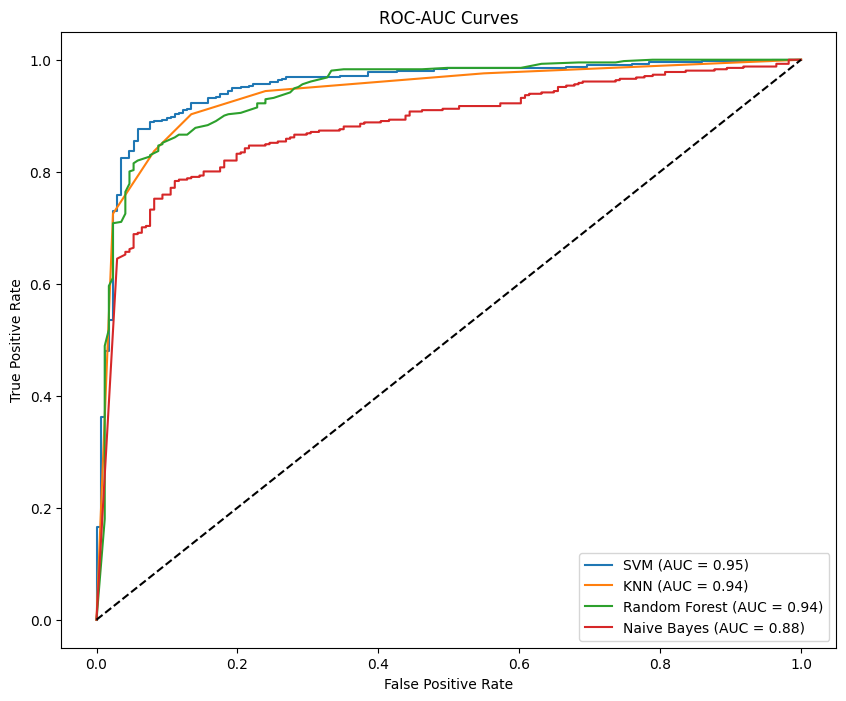

In [ ]:
import numpy as np
import cv2
import optuna
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Define models
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}

# Train and predict with models
preds = {}
probs = {}
for name, model in models.items():
    model.fit(train_features, train_labels_encoded)
    preds[name] = model.predict(test_features)
    probs[name] = model.predict_proba(test_features)[:, 1]

# Evaluate classifiers
def evaluate_model(true_labels, pred_labels, pred_probs):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    auc_roc = roc_auc_score(true_labels, pred_probs)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    mcc = matthews_corrcoef(true_labels, pred_labels)

    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    specificity = tn / (tn + fp)

    return accuracy, f1, auc_roc, precision, recall, specificity, mcc

metrics = {name: evaluate_model(test_labels_encoded, preds[name], probs[name]) for name in models.keys()}

# Plot ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model_probs in probs.items():
    fpr, tpr, _ = roc_curve(test_labels_encoded, model_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(test_labels_encoded, model_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves')
plt.legend()
plt.show()





[I 2024-07-01 08:05:36,372] A new study created in memory with name: no-name-a39e458e-1785-4cec-81d7-752ee99d2fb9
<ipython-input-9-1c9a912ebd0b>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-07-01 08:14:04,546] Trial 0 finished with value: 0.9532163742690059 and parameters: {'C': 5.97582740421312, 'kernel': 'linear'}. Best is trial 0 with value: 0.9532163742690059.
<ipython-input-9-1c9a912ebd0b>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
[I 2024-07-01 08:14:42,824] Trial 1 finished with value: 0.9641439364835446 and parameters: {'C': 0.3156304377801213, 'kernel': '

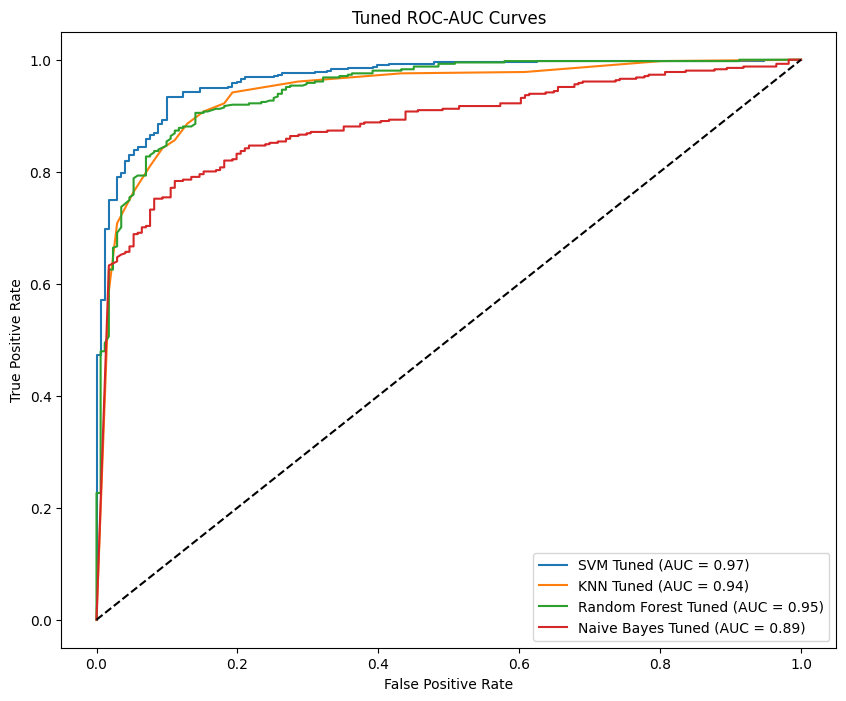

In [ ]:
# Optuna for hyperparameter tuning
def objective(trial, model_name):
    if model_name == "SVM":
        C = trial.suggest_loguniform('C', 1e-5, 1e2)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        model = SVC(C=C, kernel=kernel, probability=True)
    elif model_name == "KNN":
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model_name == "Random Forest":
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif model_name == "Naive Bayes":
        var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
        model = GaussianNB(var_smoothing=var_smoothing)

    model.fit(train_features, train_labels_encoded)
    preds = model.predict(test_features)
    probs = model.predict_proba(test_features)[:, 1]
    return roc_auc_score(test_labels_encoded, probs)

# Perform hyperparameter tuning
best_params = {}
for name in models.keys():
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, name), n_trials=50)
    best_params[name] = study.best_params

# Retrain and evaluate tuned models
tuned_preds = {}
tuned_probs = {}
tuned_metrics = {}

for name, params in best_params.items():
    if name == "SVM":
        model = SVC(**params, probability=True)
    elif name == "KNN":
        model = KNeighborsClassifier(**params)
    elif name == "Random Forest":
        model = RandomForestClassifier(**params)
    elif name == "Naive Bayes":
        model = GaussianNB(**params)

    model.fit(train_features, train_labels_encoded)
    tuned_preds[name] = model.predict(test_features)
    tuned_probs[name] = model.predict_proba(test_features)[:, 1]
    tuned_metrics[name] = evaluate_model(test_labels_encoded, tuned_preds[name], tuned_probs[name])

# Plot tuned ROC-AUC curves
plt.figure(figsize=(10, 8))
for name, model_probs in tuned_probs.items():
    fpr, tpr, _ = roc_curve(test_labels_encoded, model_probs)
    plt.plot(fpr, tpr, label=f"{name} Tuned (AUC = {roc_auc_score(test_labels_encoded, model_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned ROC-AUC Curves')
plt.legend()
plt.show()

In [ ]:
# Prepare data for CNN
def prepare_data_for_cnn(images, labels):
    images_resized = [cv2.resize(img, (224, 224)) for img in images]
    images_array = np.array(images_resized)
    images_array = images_array.reshape(-1, 224, 224, 1).astype('float32') / 255.0
    labels_array = label_encoder.transform(labels)
    return images_array, labels_array

train_images_cnn, train_labels_cnn = prepare_data_for_cnn(train_images, train_labels)
val_images_cnn, val_labels_cnn = prepare_data_for_cnn(val_images, val_labels)
test_images_cnn, test_labels_cnn = prepare_data_for_cnn(test_images, test_labels)


# Define and compile CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train CNN model
cnn_history = cnn_model.fit(train_images_cnn, train_labels_cnn, epochs=50, validation_data=(val_images_cnn, val_labels_cnn), callbacks=[early_stopping])

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_images_cnn, test_labels_cnn)
cnn_preds = cnn_model.predict(test_images_cnn).flatten()
cnn_pred_labels = (cnn_preds > 0.5).astype(int)

cnn_metrics = evaluate_model(test_labels_cnn, cnn_pred_labels, cnn_preds)




In [ ]:
# Summary of all models' metrics
models_metrics = {
    "SVM": metrics["SVM"],
    "KNN": metrics["KNN"],
    "Random Forest": metrics["Random Forest"],
    "Naive Bayes": metrics["Naive Bayes"],
    "CNN": cnn_metrics
}

tuned_models_metrics = {
    "SVM": tuned_metrics["SVM"],
    "KNN": tuned_metrics["KNN"],
    "Random Forest": tuned_metrics["Random Forest"],
    "Naive Bayes": tuned_metrics["Naive Bayes"],
    "CNN": cnn_metrics
}


In [ ]:
# Print metrics before and after tuning
for model_name, metrics in models_metrics.items():
    print(f"{model_name} Metrics: ")
    print(f"Accuracy: {metrics[0]}")
    print(f"F1 Score: {metrics[1]}")
    print(f"AUC-ROC: {metrics[2]}")
    print(f"Precision: {metrics[3]}")
    print(f"Sensitivity: {metrics[4]}")
    print(f"Specificity: {metrics[5]}")
    print(f"MCC: {metrics[6]}\n")

print("Metrics after hyperparameter tuning:\n")
for model_name, metrics in tuned_models_metrics.items():
    print(f"{model_name} Tuned Metrics: ")
    print(f"Accuracy: {metrics[0]}")
    print(f"F1 Score: {metrics[1]}")
    print(f"AUC-ROC: {metrics[2]}")
    print(f"Precision: {metrics[3]}")
    print(f"Sensitivity: {metrics[4]}")
    print(f"Specificity: {metrics[5]}")
    print(f"MCC: {metrics[6]}\n")

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, matthews_corrcoef

# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Train SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features, train_labels_encoded)
svm_preds = svm.predict(test_features)
svm_probs = svm.predict_proba(test_features)[:, 1]

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels_encoded)
knn_preds = knn.predict(test_features)
knn_probs = knn.predict_proba(test_features)[:, 1]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_features, train_labels_encoded)
rf_preds = rf.predict(test_features)
rf_probs = rf.predict_proba(test_features)[:, 1]

# Train Naive Bayes
nb = GaussianNB()
nb.fit(train_features, train_labels_encoded)
nb_preds = nb.predict(test_features)
nb_probs = nb.predict_proba(test_features)[:, 1]

# Evaluate classifiers
def evaluate_model(true_labels, pred_labels, pred_probs):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    auc_roc = roc_auc_score(true_labels, pred_probs)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    mcc = matthews_corrcoef(true_labels, pred_labels)

    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
    specificity = tn / (tn + fp)

    return accuracy, f1, auc_roc, precision, recall, specificity, mcc

svm_metrics = evaluate_model(test_labels_encoded, svm_preds, svm_probs)
knn_metrics = evaluate_model(test_labels_encoded, knn_preds, knn_probs)
rf_metrics = evaluate_model(test_labels_encoded, rf_preds, rf_probs)
nb_metrics = evaluate_model(test_labels_encoded, nb_preds, nb_probs)

print("SVM Metrics: ", svm_metrics)
print("KNN Metrics: ", knn_metrics)
print("Random Forest Metrics: ", rf_metrics)
print("Naive Bayes Metrics: ", nb_metrics)


SVM Metrics:  (0.9054982817869416, 0.9055784865811124, 0.9514377996898167, 0.9056648402734327, 0.9054982817869416, 0.8421052631578947, 0.7726660799996711)
KNN Metrics:  (0.8831615120274914, 0.8842763551016798, 0.9294261606977703, 0.8862213841177221, 0.8831615120274914, 0.8362573099415205, 0.7249573415352742)
Random Forest Metrics:  (0.8780068728522337, 0.8800946459164903, 0.9447574735703818, 0.8851365713678393, 0.8780068728522337, 0.8596491228070176, 0.7201613342103189)
Naive Bayes Metrics:  (0.8109965635738832, 0.8177899518112418, 0.8861143125453537, 0.8429905667637244, 0.8109965635738832, 0.8596491228070176, 0.6046597805980838)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prepare data for CNN
def prepare_data_for_cnn(images, labels):
    images_resized = [cv2.resize(img, (224, 224)) for img in images]
    images_array = np.array(images_resized)
    images_array = images_array.reshape(-1, 224, 224, 1).astype('float32') / 255.0
    labels_array = label_encoder.transform(labels)
    return images_array, labels_array

train_images_cnn, train_labels_cnn = prepare_data_for_cnn(train_images, train_labels)
val_images_cnn, val_labels_cnn = prepare_data_for_cnn(val_images, val_labels)
test_images_cnn, test_labels_cnn = prepare_data_for_cnn(test_images, test_labels)

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_history = cnn_model.fit(train_images_cnn, train_labels_cnn, epochs=50, validation_data=(val_images_cnn, val_labels_cnn), callbacks=[Early_stopping])

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_images_cnn, test_labels_cnn)
cnn_preds = cnn_model.predict(test_images_cnn).flatten()
cnn_pred_labels = (cnn_preds > 0.5).astype(int)

cnn_metrics = evaluate_model(test_labels_cnn, cnn_pred_labels, cnn_preds)
print("CNN Metrics: ", cnn_metrics)


NameError: name 'early_stopping' is not defined

In [ ]:
# Summary of all models' metrics
models_metrics = {
    "SVM": svm_metrics,
    "KNN": knn_metrics,
    "Random Forest": rf_metrics,
    "Naive Bayes": nb_metrics,
    "CNN": cnn_metrics
}

for model_name, metrics in models_metrics.items():
    print(f"{model_name} Metrics: ")
    print(f"Accuracy: {metrics[0]}")
    print(f"F1 Score: {metrics[1]}")
    print(f"AUC-ROC: {metrics[2]}")
    print(f"Precision: {metrics[3]}")
    print(f"Sensitivity: {metrics[4]}")
    print(f"Specificity: {metrics[5]}")
    print(f"MCC: {metrics[6]}\n")


NameError: name 'svm_metrics' is not defined